In [5]:
%pylab inline
import matplotlib.pyplot as plt 
import numpy as np
import cv2
np.seterr(all='raise')

Populating the interactive namespace from numpy and matplotlib


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [6]:
def nd(l):
    return np.array(l,dtype=float)
def Vis(U):
# Visualizing A Cluster
    img=U/U.max()
    img=(img*255).astype(int)
    plt.imshow(img,cmap='gray')
    plt.show()
def VisCrisp(U):
    img=(U==numpy.amax(U,axis=(0)))*255
    for Map in img:
        Vis(Map)

In [7]:
def normalizeImage(img):
    minPx,maxPx=img.min(),img.max()
    NormalizedImg = (img-minPx)/(maxPx-minPx)
    return NormalizedImg

In [8]:
def getVar(X):
    n=X.shape[1]*X.shape[2]
    mean=X.sum(axis=(1,2))/n
    Var=np.power(X-mean[:,np.newaxis,np.newaxis],2)
    return Var.sum(axis=(0,1,2))/n

def sugenoNeg(mu,b=0.7):
    return (1-mu)/(1+b*mu)

def randomVMatGen(clusters):
    #V is the Centroid matrix
    mu = np.random.rand(clusters)
    nu=sugenoNeg(mu)
    V=np.array([mu,nu,1-mu-nu])
    return V

def UpCen(U,x):
    return ((U*x).sum(axis=(1,2))) / (U.sum(axis=(1,2)))

def getCentroids(X,U,K):
    #U=1-sugenoNeg(U)
    Un=U*K
    muS= UpCen(Un,X[0])
    nuS= UpCen(Un,X[1])
    piS= UpCen(Un,X[2])
    V = np.array([muS,nuS,piS])
    return V

def d2(X,Y):
    return (np.power(X-Y,2)).sum(axis=0)

def updateMatU(X,V,Var,Lambda):
    c=V.shape[1]
    D2=d2(X[:,np.newaxis,:,:],V[:,:,np.newaxis,np.newaxis])  
    K=np.exp(-D2/Var)
    const=-1/(Lambda+Var/c)
    U=np.exp(const*(1-K))
    U=U/U.sum(axis=0)
    return [U,K]

In [30]:
def fcm(mu,m=2,c=4,Lambda=0.01,e=0.0000001,maxIter=60):
    nu=sugenoNeg(mu)
    X=np.array([mu,nu,1-mu-nu])
    Var=getVar(X)
    V=randomVMatGen(c)
    ind=1
    k=list(X.shape)
    k[0]=c
    U_prev=zeros(k)
    while ind<maxIter:
        U,K=updateMatU(X,V,Var,Lambda)
        V=getCentroids(X,U,K)
#         if (np.absolute(U-U_prev)).max() < e:
#             break
        U_prev=U
        ind+=1
    print(ind)
    return U,V    

In [17]:
def printImg(img):
    plt.imshow(img,cmap='gray')
    plt.show()
    
def GetImg(FileName):
    import os
    cwd = os.getcwd()
    img = cv2.imread(cwd+'\\Img\\'+FileName, cv2.IMREAD_GRAYSCALE)
    return img

def GetMap(U):
    Map=(U==numpy.amax(U,axis=(0))).astype(int)
    return Map

def GetGroundTurthMaps(FileName='NewImg2.tiff'):
    import os
    cwd = os.getcwd()
    img1 = GetImg(FileName)
    uniq=np.unique(img1)
    uniq.sort()
    Map=[]
    for i in range(uniq.size):
        Map.append(img1==uniq[i])
    return nd(Map),uniq,img1

def GetResMaps(res,getGrndTruth=0):
    img=GetImg('NewImg2.tiff')
    Maps=GetMap(res[0])
    Maps=nd(Maps)
    Avg=np.zeros(Maps.shape[0])
    for i in range(Maps.shape[0]):
        if Maps[i].sum() == 0:
            Avg[i]=0
        else:
            Avg[i]=(img*Maps[i]).sum()/Maps[i].sum()
    Ord=numpy.argsort(Avg)
    Maps=Maps[Ord]
    #Maps=Maps*Inten[:,np.newaxis,np.newaxis] #To get the colored resultant
    return Maps

In [27]:
def DiceScore(G,R):
    intersectionPx=2*(G*R).sum(axis=(1,2))
    return intersectionPx/(G+R).sum(axis=(1,2))
def AvgSegAcc(G,R):
    intersectionPx=(G*R).sum()
    return intersectionPx/G.sum()
def Scores(G,R):
    return DiceScore(G,R),AvgSegAcc(G,R)

def GetScores(FileName,G,printResMap=1):
    res=fcm(GetImg(FileName))
    R=GetResMaps(res)
    if printResMap:
        for seg in R:
            printImg(seg)
    return Scores(G,R)

def GetAllImgScores(printResMap=1):
    import os
    path = os.getcwd()+'\\Img'
    Files=os.listdir(path)
    G,a,b=GetGroundTurthMaps()
    FilesScr={}
    for file in Files:
        FilesScr[file]=GetScores(file,G,printResMap)
        print(FilesScr[file])
    return FilesScr

In [18]:
GetAllImgScores()

1
(array([0.        , 0.        , 0.        , 0.85604213]), 0.6671157059314954)
1
(array([8.74092534e-01, 8.60955661e-05, 0.00000000e+00, 8.53491697e-01]), 0.7513627819548873)
1
(array([0.57852257, 0.        , 0.        , 0.85997752]), 0.7112781954887218)
1
(array([0.68000508, 0.00979351, 0.        , 0.86574648]), 0.7237625313283208)
1
(array([0.9748417 , 0.01924724, 0.        , 0.8624039 ]), 0.773015873015873)


{'NewImg2.tiff': (array([0.        , 0.        , 0.        , 0.85604213]),
  0.6671157059314954),
 'NewImg2_0_001.tiff': (array([8.74092534e-01, 8.60955661e-05, 0.00000000e+00, 8.53491697e-01]),
  0.7513627819548873),
 'NewImg2_0_002.tiff': (array([0.57852257, 0.        , 0.        , 0.85997752]),
  0.7112781954887218),
 'NewImg2_0_003.tiff': (array([0.68000508, 0.00979351, 0.        , 0.86574648]),
  0.7237625313283208),
 'NewImg2_0_004.tiff': (array([0.9748417 , 0.01924724, 0.        , 0.8624039 ]),
  0.773015873015873)}

In [20]:
GetAllImgScores()

1
(array([0.        , 0.        , 0.        , 0.85604213]), 0.6671157059314954)
1
(array([1.92455735e-04, 0.00000000e+00, 0.00000000e+00, 8.53828213e-01]), 0.6671261487050961)
1
(array([0.61909034, 0.        , 0.        , 0.8302208 ]), 0.7157633667502089)
1
(array([0.05557635, 0.        , 0.        , 0.84822211]), 0.6702172096908939)
1
(array([0.92578714, 0.24007901, 0.        , 0.87282589]), 0.7868577694235589)


{'NewImg2.tiff': (array([0.        , 0.        , 0.        , 0.85604213]),
  0.6671157059314954),
 'NewImg2_0_001.tiff': (array([1.92455735e-04, 0.00000000e+00, 0.00000000e+00, 8.53828213e-01]),
  0.6671261487050961),
 'NewImg2_0_002.tiff': (array([0.61909034, 0.        , 0.        , 0.8302208 ]),
  0.7157633667502089),
 'NewImg2_0_003.tiff': (array([0.05557635, 0.        , 0.        , 0.84822211]),
  0.6702172096908939),
 'NewImg2_0_004.tiff': (array([0.92578714, 0.24007901, 0.        , 0.87282589]),
  0.7868577694235589)}

In [26]:
GetAllImgScores()

6
(array([0.        , 0.        , 0.53672867, 1.        ]), 0.7892178362573099)
8
(array([0.        , 0.        , 0.39466356, 0.86007182]), 0.625438596491228)
9
(array([0.        , 0.        , 0.36744891, 0.81362007]), 0.5796104845446951)
8
(array([0.        , 0.        , 0.36466338, 0.80855766]), 0.5748068086883876)
8
(array([0.        , 0.        , 0.35591295, 0.79131438]), 0.5587875939849624)


{'NewImg2.tiff': (array([0.        , 0.        , 0.53672867, 1.        ]),
  0.7892178362573099),
 'NewImg2_0_001.tiff': (array([0.        , 0.        , 0.39466356, 0.86007182]),
  0.625438596491228),
 'NewImg2_0_002.tiff': (array([0.        , 0.        , 0.36744891, 0.81362007]),
  0.5796104845446951),
 'NewImg2_0_003.tiff': (array([0.        , 0.        , 0.36466338, 0.80855766]),
  0.5748068086883876),
 'NewImg2_0_004.tiff': (array([0.        , 0.        , 0.35591295, 0.79131438]),
  0.5587875939849624)}

6


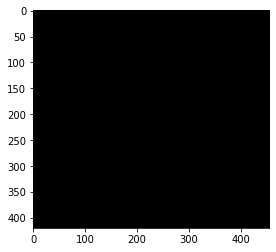

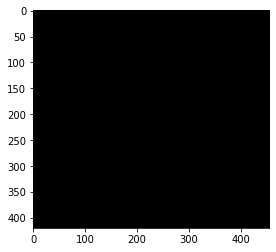

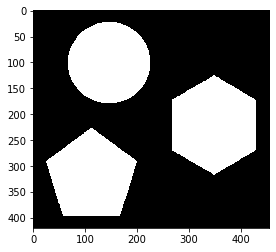

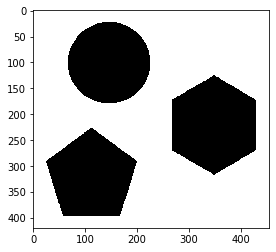

(array([0.        , 0.        , 0.53672867, 1.        ]), 0.7892178362573099)
8


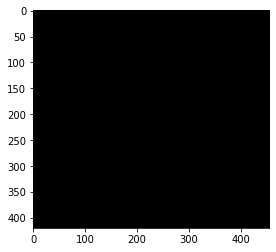

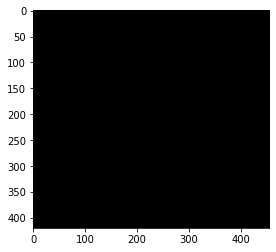

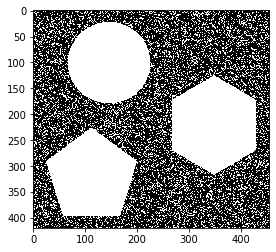

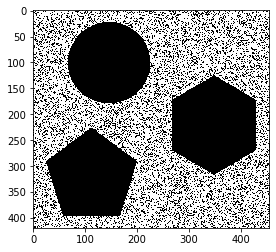

(array([0.        , 0.        , 0.39466356, 0.86007182]), 0.625438596491228)
8


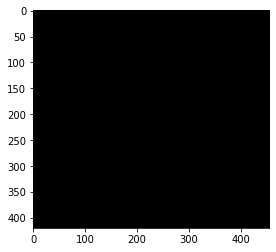

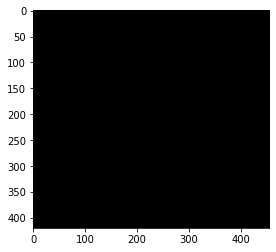

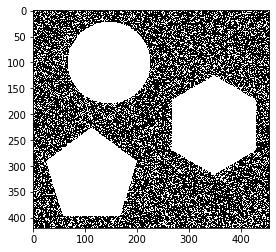

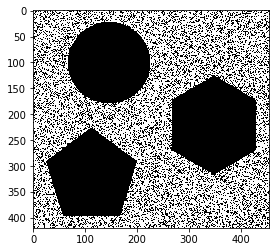

(array([0.        , 0.        , 0.37912195, 0.83482059]), 0.6000730994152047)
8


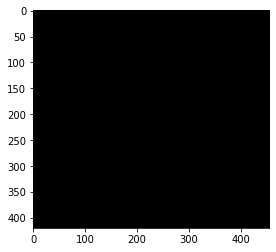

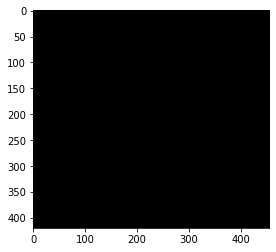

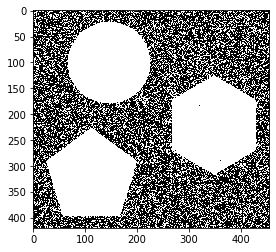

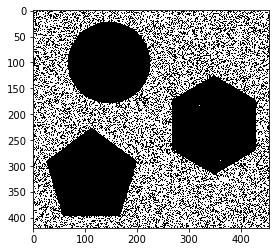

(array([0.        , 0.        , 0.36466338, 0.80855766]), 0.5748068086883876)
8


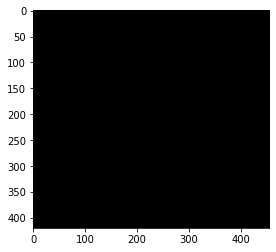

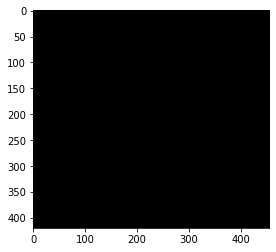

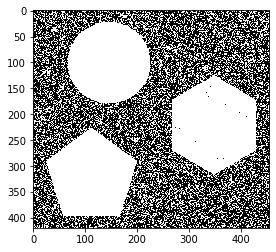

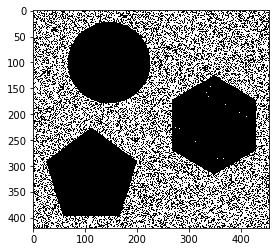

(array([0.        , 0.        , 0.35591295, 0.79131438]), 0.5587875939849624)


{'NewImg2.tiff': (array([0.        , 0.        , 0.53672867, 1.        ]),
  0.7892178362573099),
 'NewImg2_0_001.tiff': (array([0.        , 0.        , 0.39466356, 0.86007182]),
  0.625438596491228),
 'NewImg2_0_002.tiff': (array([0.        , 0.        , 0.37912195, 0.83482059]),
  0.6000730994152047),
 'NewImg2_0_003.tiff': (array([0.        , 0.        , 0.36466338, 0.80855766]),
  0.5748068086883876),
 'NewImg2_0_004.tiff': (array([0.        , 0.        , 0.35591295, 0.79131438]),
  0.5587875939849624)}

In [29]:
GetAllImgScores()

60


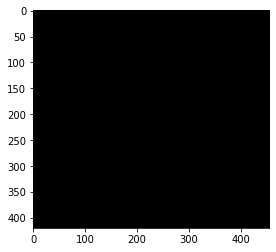

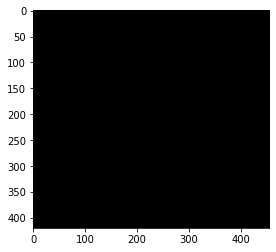

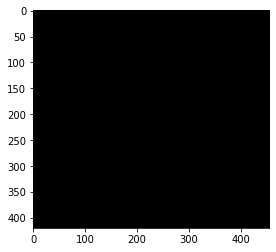

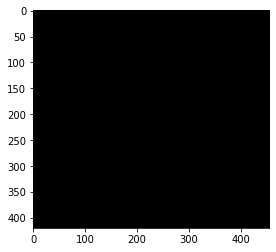

(array([0.19577771, 0.18556467, 0.21763105, 0.80032322]), 1.0)
60


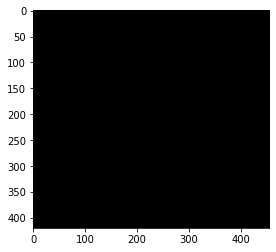

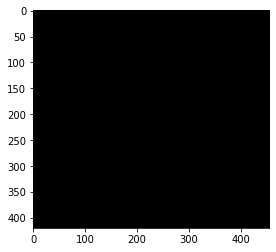

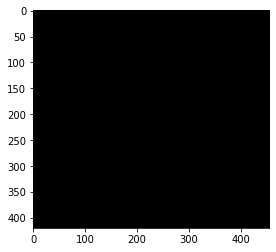

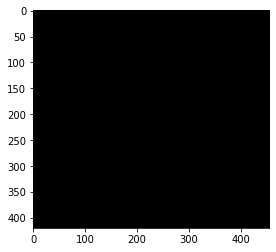

(array([0.19577771, 0.18556467, 0.21763105, 0.80032322]), 1.0)
60


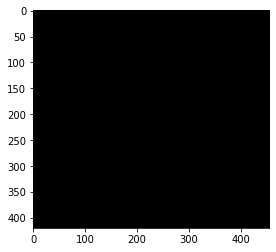

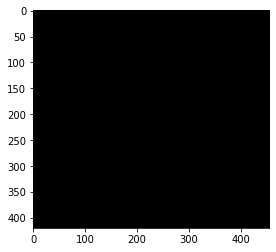

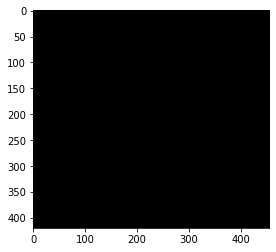

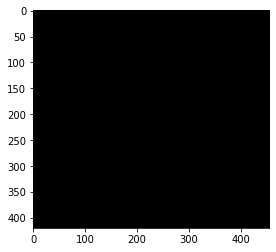

(array([0.19577771, 0.18556467, 0.21763105, 0.80032322]), 1.0)
60


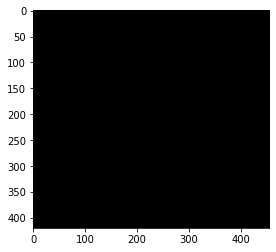

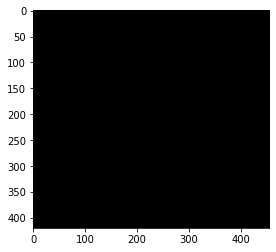

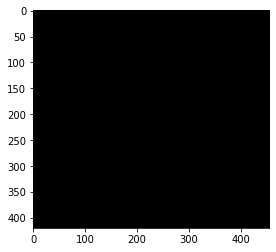

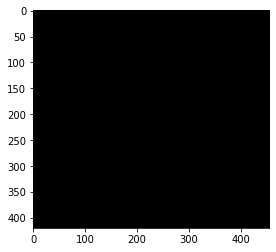

(array([0.19577771, 0.18556467, 0.21763105, 0.80032322]), 1.0)
60


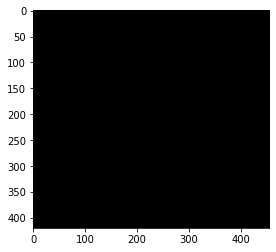

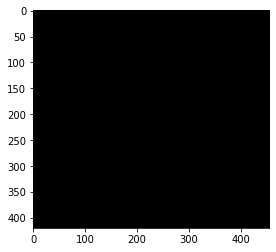

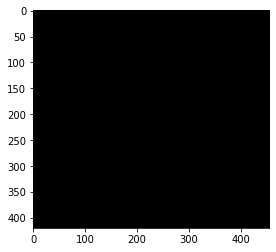

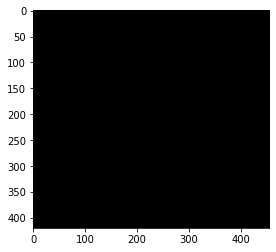

(array([0.19577771, 0.18556467, 0.21763105, 0.80032322]), 1.0)


{'NewImg2.tiff': (array([0.19577771, 0.18556467, 0.21763105, 0.80032322]),
  1.0),
 'NewImg2_0_001.tiff': (array([0.19577771, 0.18556467, 0.21763105, 0.80032322]),
  1.0),
 'NewImg2_0_002.tiff': (array([0.19577771, 0.18556467, 0.21763105, 0.80032322]),
  1.0),
 'NewImg2_0_003.tiff': (array([0.19577771, 0.18556467, 0.21763105, 0.80032322]),
  1.0),
 'NewImg2_0_004.tiff': (array([0.19577771, 0.18556467, 0.21763105, 0.80032322]),
  1.0)}

In [31]:
GetAllImgScores()

60


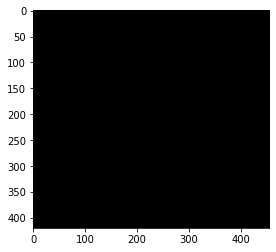

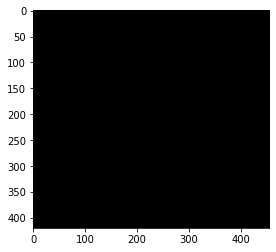

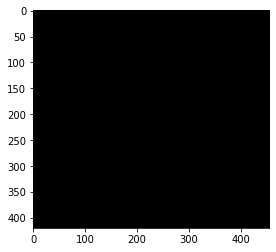

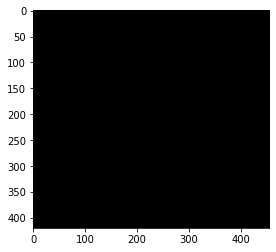

(array([0.19577771, 0.18556467, 0.21763105, 0.80032322]), 1.0)
60


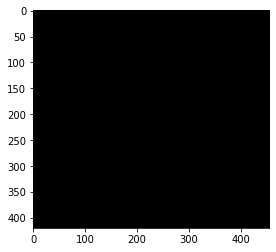

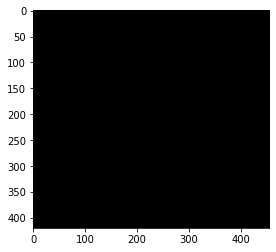

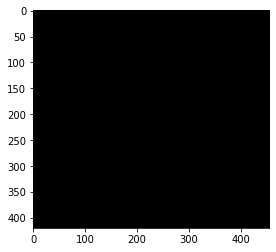

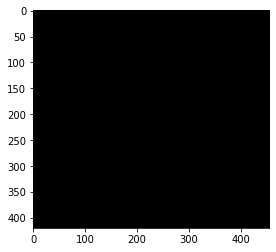

(array([0.19577771, 0.18556467, 0.21763105, 0.80032322]), 1.0)
60


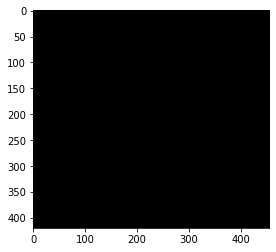

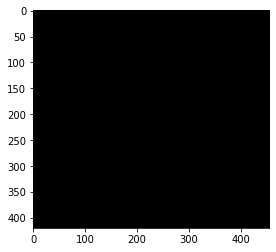

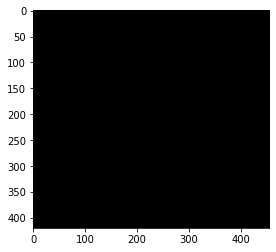

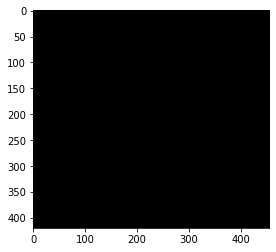

(array([0.19577771, 0.18556467, 0.21763105, 0.80032322]), 1.0)
60


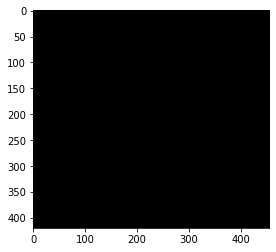

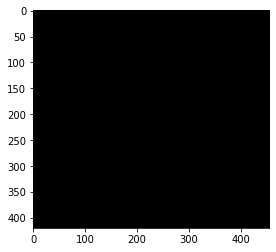

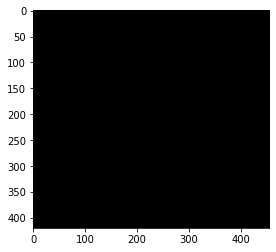

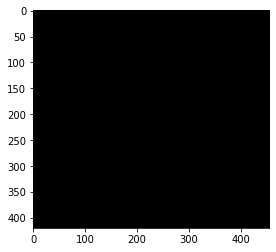

(array([0.19577771, 0.18556467, 0.21763105, 0.80032322]), 1.0)
60


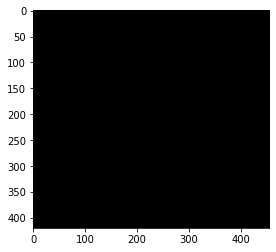

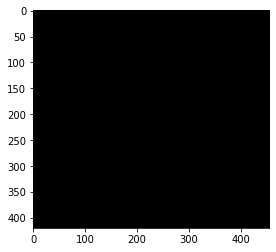

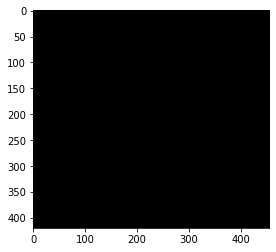

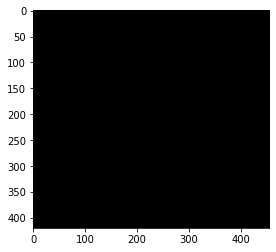

(array([0.19577771, 0.18556467, 0.21763105, 0.80032322]), 1.0)


{'NewImg2.tiff': (array([0.19577771, 0.18556467, 0.21763105, 0.80032322]),
  1.0),
 'NewImg2_0_001.tiff': (array([0.19577771, 0.18556467, 0.21763105, 0.80032322]),
  1.0),
 'NewImg2_0_002.tiff': (array([0.19577771, 0.18556467, 0.21763105, 0.80032322]),
  1.0),
 'NewImg2_0_003.tiff': (array([0.19577771, 0.18556467, 0.21763105, 0.80032322]),
  1.0),
 'NewImg2_0_004.tiff': (array([0.19577771, 0.18556467, 0.21763105, 0.80032322]),
  1.0)}

In [32]:
GetAllImgScores()